In [1]:
%matplotlib inline
import matplotlib

In [2]:
import pynedm
from pynedm.utils import ProcessObject
import json

_db_name = "nedm%2Ftemperature_environment"

# Authentication
po = ProcessObject("http://10.155.59.88:5984",
                   "un",
                   "pw", _db_name)
acct = po.acct

# Grab the correct database
db = acct[_db_name]

# Reads all data from a certain time
des = db.design("document_type")
the_view = des.view("document_type")



In [3]:
import numpy
import json

class BadFile(Exception):
    pass

def print_out_file(af):
    af.seek(0)
    rd_in = af.read(4)
    if rd_in[0] == "{": raise BadFile()
    hdr_length = numpy.frombuffer(rd_in, dtype=numpy.uint32)[0]
    hdr = json.loads(af.read(hdr_length))
    atype = getattr(numpy,hdr["type"])
    return (numpy.fromstring(af.read(), dtype=atype), hdr)

In [7]:
to_db = "nedm%2Ftemperature_environment"
copy_to_db = acct[to_db]

from clint.textui.progress import Bar as ProgressBar

class callback():
    def __init__(self):
        self.bar = None
        
    def __call__(self, read, total):
        if self.bar is None:
            self.bar = ProgressBar(expected_size=total, filled_char='=')
        self.bar.show(read)

def copy_document(adoc):

    new_doc = adoc.copy()
    #print new_doc
    files = new_doc["external_docs"]
    for o in ["_rev", "external_docs"]:
        del new_doc[o]
    #print new_doc        
    ret = copy_to_db.post(data=json.dumps(new_doc))
    ret.raise_for_status()
    #print json.dumps(ret.json(), indent=4)
    for f in files:
        af = po.open_file(adoc["_id"], f)
        uploading = po.upload_file(af, new_doc["_id"], attachment_name=f, db=to_db, callback=callback())
        #print json.dumps(uploading, indent=4)


31


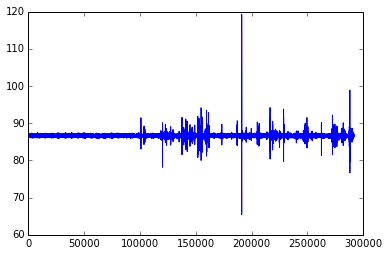

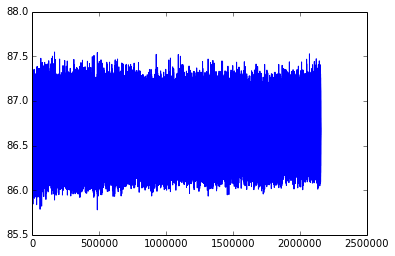

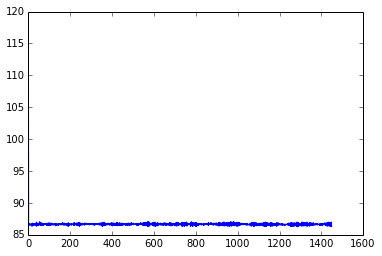

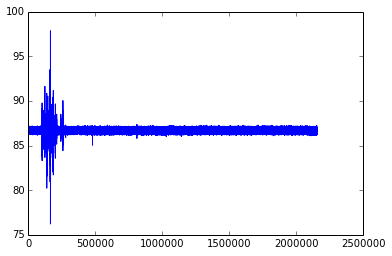

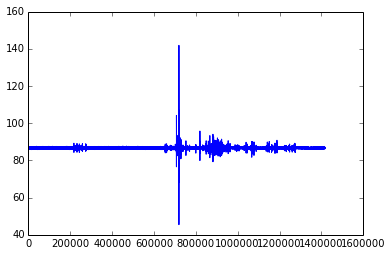

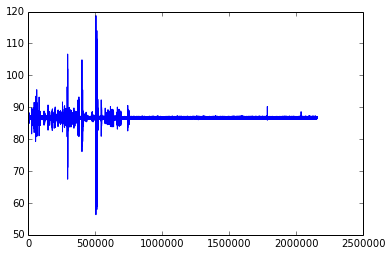

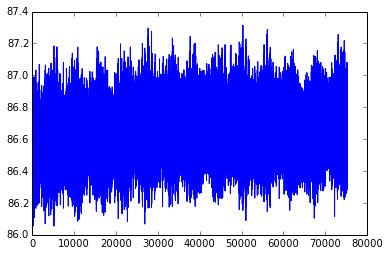

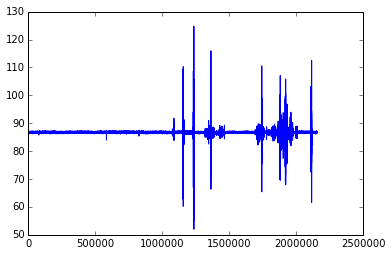

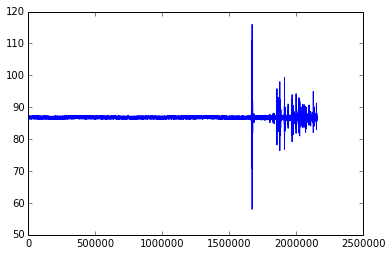

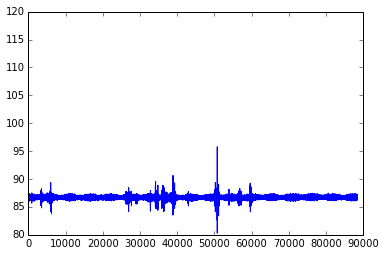

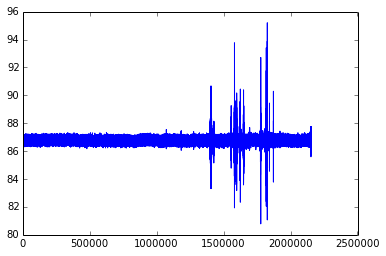

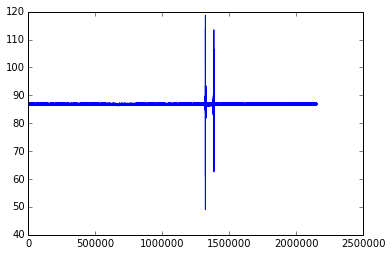

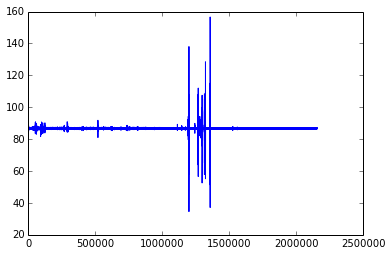

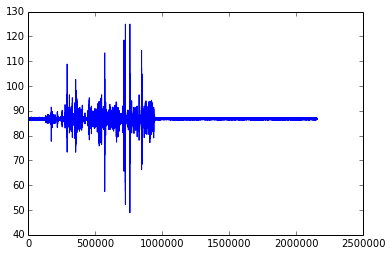

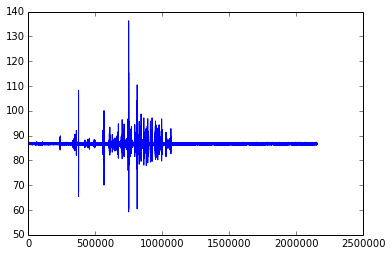

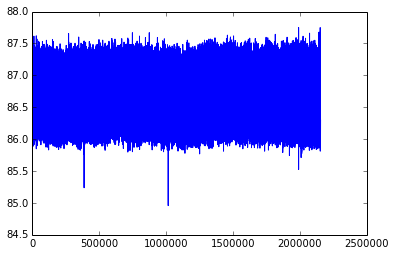

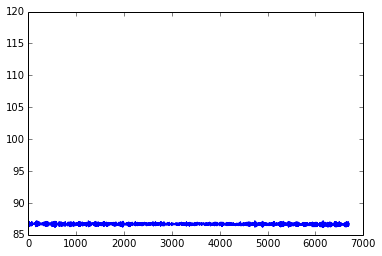

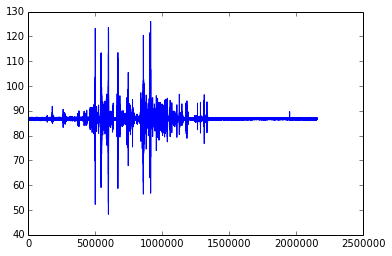

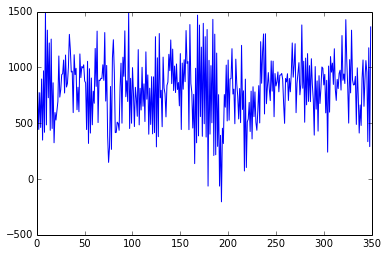

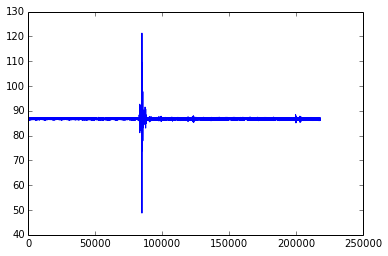

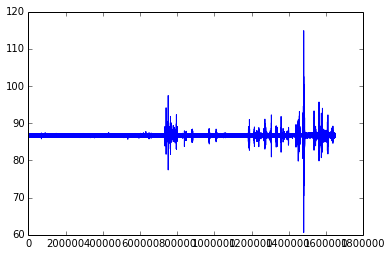

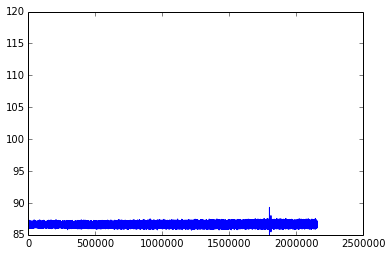

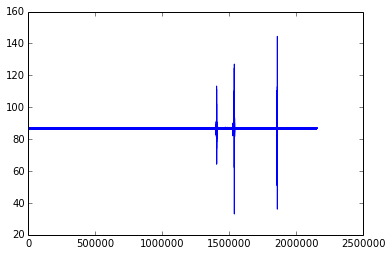

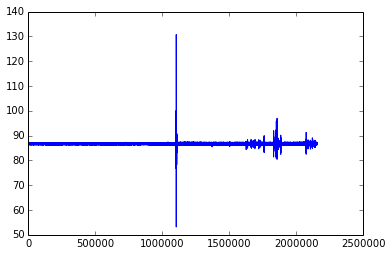

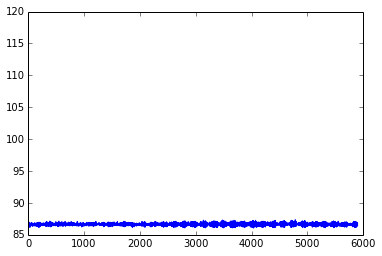

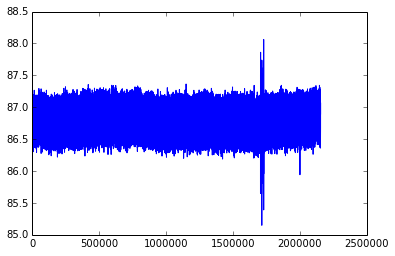

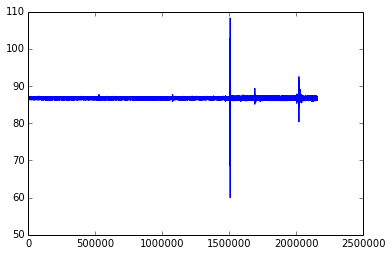

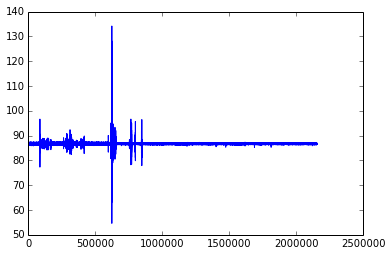

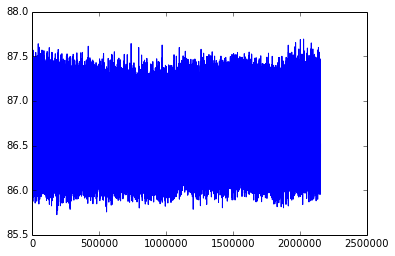

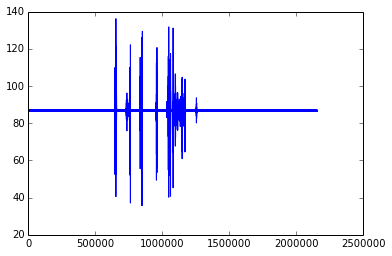

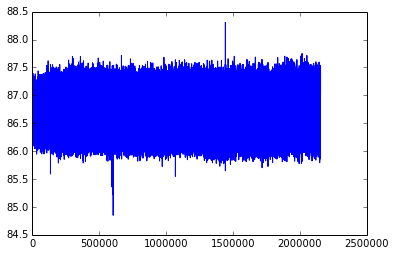

In [4]:
import traceback
from matplotlib import pyplot as plt
# Can read all data with a certain key from a certain time
results = the_view.get(params=dict(
                                   endkey=['vibration_measurement', {}],
                                   startkey=['vibration_measurement'],
                                   include_docs=True,
                                   reduce=False
                                   )   
                      ).json()

list_of_ids = dict([(d["id"], d["doc"]) 
                    for d in results["rows"] 
                    if "external_docs" in d["doc"]])

print len(list_of_ids)
for ad,v in list_of_ids.items():
    try:
        #copy_document(v)
        #x = db.document(ad)
        #curr = x.get().json()
        #print x.delete(curr["_rev"]).json()        
        af = po.open_file(ad, "time")
        arr, hdr = print_out_file(af)
        plt.plot(arr)
        plt.show()
    except BadFile:
        print("Problem with {}".format(ad))
    except:
        print ad
        traceback.print_exc()